# Cross Validation with Sliding Window

[Reference](https://towardsdatascience.com/predicting-future-stock-market-trends-with-python-machine-learning-2bf3f1633b3c)

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

In [2]:
def convert(date_string):
    year, month, day = [int(i) for i in date_string.split('-')]
    return datetime(year=year, month=month, day=day)

### (Part0) Prepare Data & Helper Functions

In [3]:
def prepare_dataset(path = 'data/AAPL_data.csv', select_feature = True, sentiment = False, start_date = '2021-12-29'):
    '''
    Load dataset and generate technical features and limit time periods. 

    path(str) : path to the data file.
    select_feature(boolean) : if true keep selected features.
    sentiment(boolean) : if true add sentiment score.
    start_date(str) : start date of interested time period. 
    '''
    df = pd.read_csv(path)
    df.dropna()

    df["Date"]=pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index=df['Date']
    data = df.sort_index(ascending=True, axis=0)
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    df = add_all_ta_features(
        df, high="High", low="Low", open="Open", close="Close", volume="Volume")
    
    df = df[df['Date'] >= start_date]


    y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

    if sentiment:
        df.index = np.array(range(len(df)))
        df_sentiment = pd.read_csv('data/AAPL_stocktwits_sentiment.csv')
        df_sentiment.date = df_sentiment.date.apply(convert)
        df_sentiment.rename(columns={'date':'Date'}, inplace=True)
        df=df.merge(df_sentiment, how='left', on='Date').fillna(0)


    X = df.drop(['Close', 'trend_psar_down', 'trend_psar_up', 'Date', 'Adj Close'], axis=1)

    if select_feature:
        selected_features = ['trend_sma_fast', 'trend_ema_fast', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_rsi', \
                    'trend_macd', 'momentum_wr', 'volume_adi', 'momentum_roc', 'volume_obv', \
                    'volatility_bbh', 'volatility_bbl']
        basic_features = ['High', 'Low', 'Open', 'Volume', 'Year', 'Month', 'Week', 'Day', 'Dayofweek']
        X = X[selected_features + basic_features]

    X = X.astype(np.float32)
    return np.array(X), y


In [4]:
def logistic_regression(X_train, X_test, y_train, y_test):
    '''
    Run logistic regression and return model and accuracy score. 
    '''
    model = LogisticRegression(max_iter=float('inf'))
    model = model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model, model.score(X_test, y_test)

In [5]:
def random_forest(X_train, X_test, y_train, y_test):
    '''
    Run random forest and return model and accuracy score. 
    '''
    model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=3, max_features='log2')
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    return model, model.score(X_test, y_test)

In [6]:
def adaboost(X_train, X_test, y_train, y_test):
    '''
    Run adaboost and return model and accuracy score. 
    '''   
    model = AdaBoostClassifier(random_state=42, n_estimators=100, algorithm='SAMME')
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    return model, model.score(X_test, y_test)

In [7]:
def gradient_boost(X_train, X_test, y_train, y_test):
    '''
    Run gradient boosting and return model and accuracy score. 
    '''       
    model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate = 0.001, max_depth = 3, loss = 'exponential')
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    return model, model.score(X_test, y_test)

In [8]:

def ensemble_model(logit_model, rf_model, ada_model, gradient_model, X_train, X_test, y_train, y_test):
    '''
    Combine LR, RF, AB, GB to generate ensemble model and return model and accuracy score. 
    '''   
    estimators=[('logit', logit_model), ('rf', rf_model), ('ada', ada_model), ('gradient', gradient_model)]

    # Create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='hard')
    ensemble.fit(X_train, y_train)
    prediction = ensemble.predict(X_test)
    return ensemble, ensemble.score(X_test, y_test)

In [9]:
def cross_validation(df_X, df_y, len_train, verbose=True):
    '''
    Implement cross validation of each model by sliding window method. 

    df_X, df_y (np): dataset
    len_train (int): size of window
    '''

    num_step = 1
    
    logit_results = []
    rf_results = []
    ada_results = []
    gradient_results = []
    ensemble_results = []

    i = 0
    while True:
        X = df_X[i * num_step : (i * num_step) + len_train]
        y = df_y[i * num_step : (i * num_step) + len_train]
        i += 1

        if len(X) < len_train:
            break

        split = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
        
        t_scaler = MinMaxScaler()
        X_train = t_scaler.fit_transform(X_train)
        X_test = t_scaler.transform(X_test)

        if len(np.unique(y_train)) == 1:
            continue
        logit, logit_accuracy = logistic_regression(X_train, X_test, y_train, y_test)
        logit_results.append(logit_accuracy)
        rf, rf_accuracy = random_forest(X_train, X_test, y_train, y_test)
        rf_results.append(rf_accuracy)
        ada, ada_accuracy = adaboost(X_train, X_test, y_train, y_test)
        ada_results.append(ada_accuracy)
        gra, gra_accuracy = gradient_boost(X_train, X_test, y_train, y_test)
        gradient_results.append(gra_accuracy)
        _, ensemble_accuracy = ensemble_model(logit, rf, ada, gra, X_train, X_test, y_train, y_test)
        ensemble_results.append(ensemble_accuracy)

    if verbose:
        print("Mean Accuracy of Logistic Regression", sum(logit_results)/len(logit_results))
        print("Mean Accuracy of Random Forests", sum(rf_results)/len(rf_results))
        print("Mean Accuracy of Adaboost", sum(ada_results)/len(ada_results))
        print("Mean Accuracy of Gradient Boosting", sum(gradient_results)/len(gradient_results))
        print("Mean Accuracy of Ensemble", sum(ensemble_results)/len(ensemble_results))

    return sum(ensemble_results)/len(ensemble_results)

### (Part1) Implement cross validation

***With all technical features & Without sentiment score***

In [10]:
X, y = prepare_dataset(select_feature=False)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [11]:
cross_validation(X, y, 14)

Mean Accuracy of Logistic Regression 0.5380952380952381
Mean Accuracy of Random Forests 0.5619047619047621
Mean Accuracy of Adaboost 0.5190476190476191
Mean Accuracy of Gradient Boosting 0.5571428571428567
Mean Accuracy of Ensemble 0.557142857142857


0.557142857142857

***With all technical features & sentiment score***

In [12]:
X_s, y_s = prepare_dataset(select_feature=False, sentiment=True)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [13]:
cross_validation(X_s, y_s, 14)

Mean Accuracy of Logistic Regression 0.5428571428571429
Mean Accuracy of Random Forests 0.542857142857143
Mean Accuracy of Adaboost 0.5619047619047621
Mean Accuracy of Gradient Boosting 0.5666666666666663
Mean Accuracy of Ensemble 0.580952380952381


0.580952380952381

### (Part2) Evaluate optimal sliding window size

In [14]:
window_size = np.linspace(start = 10, stop = 30, num = 11, dtype = int)

accuracies = []
for size in window_size:
    accuracies.append(cross_validation(X, y, size, False))


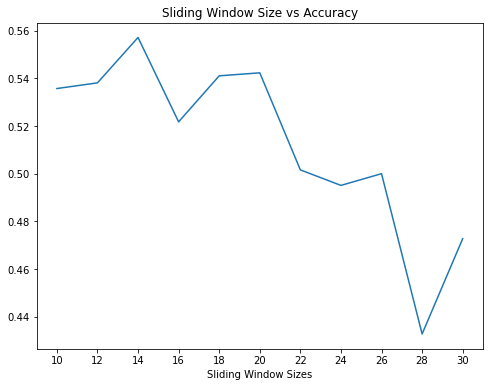

In [15]:
plt.figure(figsize=[8., 6.])
plt.plot(window_size, accuracies)
plt.title('Sliding Window Size vs Accuracy')
plt.xlabel('Sliding Window Sizes')
plt.xticks(window_size)
plt.show()

Sliding window size = 14 is the optimal. 